0
tensor([[0.0000, 3.0000, 0.0000],
        [0.0000, 6.0000, 0.0000],
        [3.0000, 0.0000, 0.0000],
        [3.0000, 3.0000, 1.1148],
        [3.0000, 6.0000, 1.1148],
        [3.0000, 9.0000, 0.0000],
        [6.0000, 0.0000, 0.0000],
        [6.0000, 3.0000, 1.1148],
        [6.0000, 6.0000, 1.1148],
        [6.0000, 9.0000, 0.0000],
        [9.0000, 3.0000, 0.0000],
        [9.0000, 6.0000, 0.0000]], grad_fn=<CloneBackward0>)
tensor(1.1148, grad_fn=<DivBackward0>)
tensor([[0.0000, 3.0000, 0.0000],
        [0.0000, 6.0000, 0.0000],
        [3.0000, 0.0000, 0.0000],
        [3.0000, 3.0000, 1.1148],
        [3.0000, 6.0000, 1.1148],
        [3.0000, 9.0000, 0.0000],
        [6.0000, 0.0000, 0.0000],
        [6.0000, 3.0000, 1.1148],
        [6.0000, 6.0000, 1.1148],
        [6.0000, 9.0000, 0.0000],
        [9.0000, 3.0000, 0.0000],
        [9.0000, 6.0000, 0.0000]], grad_fn=<CopySlices>)
Iteration 0: Normalized Gradient = 2.485726833343506, Adaptive learning rate = 0.001
1
tensor

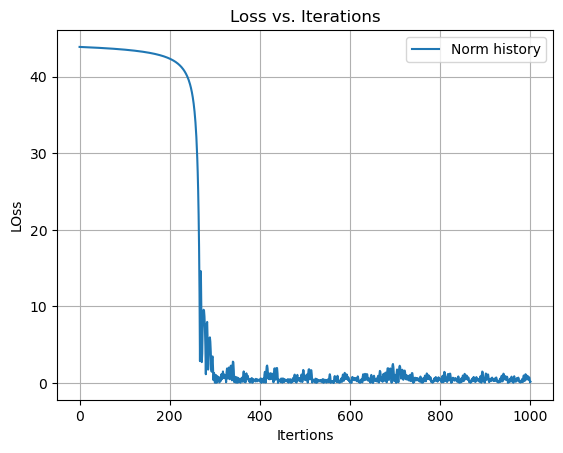

In [12]:
###### With none-FE part

import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import plotly.graph_objects as go

# q.grad.zero_()


# In[663]:


######################## explanation
## "The example model is based on a 5-nodes grid shell strcuture
##  which has a crossing projection in the x-y plane"
##  The FE part would be based on the Euler-bernoulli beam theory


# In[664]:


## Initial Geom
# Initial Coords:
node_coords = torch.tensor(
    [[0.0, 3.0, 0.0], [0.0, 6.0, 0.0], [3.0, 0.0, 0.0], [3.0, 3.0, 0.0], [3.0, 6.0, 0.0], [3.0, 9.0, 0.0],
     [6.0, 0.0, 0.0], [6.0, 3.0, 0.0], [6.0, 6.0, 0.0] ,[6.0, 9.0, 0.0], [9.0, 3.0 ,0.0], [9.0, 6.0, 0.0]],
    dtype=torch.float32, requires_grad=True, )
connectivity = [[1, 4], [2, 5], [3, 4], [5, 4], [6, 5], [4, 8], [7, 8], [9, 8],[11, 8],[10, 9],[12, 9],[5, 9]]
n_dof_per_node = 6  # Degrees of freedom per node
total_dof = n_dof_per_node * len(node_coords)
Fixed_nodes = [1, 2, 3, 6, 7, 10, 11, 12]
Free_nodes = []
n_elements = len(connectivity)
n_nodes = len(node_coords)
for i in range(1, n_nodes + 1):
    if i not in Fixed_nodes:
        Free_nodes.append(i)
idx_CF = [node - 1 for node in Fixed_nodes]
idx_CN = [i for i in range(n_nodes) if i not in idx_CF]

# In[665]:


## Force condition
####### Force condition -> need for modification
## +0 to x direction ; +1 to y direction ; +2 to Z direction
## +3 Bending around the z axis ; +4 bending around y axis ; +5 Twisting
# implement upwards loading of 50 kN at every free nodes
F = torch.zeros(total_dof, dtype=torch.float32)
f_n = Free_nodes
f_type = [2, 2, 2, 2]  # The force type
F_value = torch.tensor([50.0, 50.0, 50.0, 50.0]) * 1000  # The force value/direction
r = 1 / torch.max(F_value)
# print(r)
F_sign = torch.sign(F_value)
for idx, i in enumerate(f_n):
    F[6 * (i - 1) + f_type[idx]] = F_value[idx]  # unit: KN / KN*m

px = torch.zeros(len(f_n), 1, dtype=torch.float32)
py = torch.zeros(len(f_n), 1, dtype=torch.float32)
pz = torch.zeros(len(f_n), 1, dtype=torch.float32)

for i in range(len(f_n)):
    if f_type[idx] == 0:
        px[i] = F_value[i]
    elif f_type[idx] == 1:
        py[i] = F_value[i]
    elif f_type[idx] == 2:
        pz[i] = F_value[i]


## Obtaining Matrix D
# Assembly the nodal-branch matrix:
C = torch.zeros(n_elements, n_nodes, dtype=torch.float32)
for n, (i, j) in enumerate(connectivity):
    C[n, i - 1] = 1
    C[n, j - 1] = -1
CF = C[:, idx_CF]
CN = C[:, idx_CN]


# Assembly D
def FDM (Q,CN=CN, CF=CF, px=px, py=py, pz=pz,Fixed_nodes=Fixed_nodes, Free_nodes=Free_nodes,node_coords=node_coords) :
    Dn = torch.matmul(torch.transpose(CN, 0, 1), torch.matmul(Q, CN))
    DF = torch.matmul(torch.transpose(CN, 0, 1), torch.matmul(Q, CF))
    ## Coordinates solution
    # separate the coordinates:
    fixed_idces = [node - 1 for node in Fixed_nodes]
    xF = node_coords[fixed_idces, 0].unsqueeze(1)
    yF = node_coords[fixed_idces, 1].unsqueeze(1)
    zF = node_coords[fixed_idces, 2].unsqueeze(1)
    xN = torch.matmul(torch.inverse(Dn), (px - torch.matmul(DF, xF)))
    yN = torch.matmul(torch.inverse(Dn), (py - torch.matmul(DF, yF)))
    zN = torch.matmul(torch.inverse(Dn), (pz - torch.matmul(DF, zF)))
    ## Coordinates renewal: 
    new_node_coords = node_coords.clone()
    for idx, node in enumerate(Free_nodes):
        node_idx = node - 1
        new_node_coords[node_idx, 0] = xN[idx]
        new_node_coords[node_idx, 1] = yN[idx]
        new_node_coords[node_idx, 2] = zN[idx]

    return new_node_coords

# In[670]:

## Check point: FDM completed
# if q.grad is not None:
#     q.grad.zero_()
# loss = torch.sum(new_node_coords[:, 2])
# loss.backward()
# print("Gradient of q:")
# print(q.grad)



# Element creating
#################  input below:
############################################################################################################## input
# initial coordinates

####### BCs
fixed_dof = []
for node in Fixed_nodes:
    fixed_dof.extend([(node - 1) * 6 + i for i in range(6)])
# print(fixed_dof)
####### Gradient descent
step = 0.001
epochs = 1000

####### Plotting
steps = 20  # steps for tracing deformation shape
###################################################################################################################################################
###################################################################################################################################################


### Defining the OBJ:
Obj_coords = 45
def Average_height(Free_nodes, new_node_coords):
    n_free_nodes = len(Free_nodes)
    Free_nodes = torch.tensor(Free_nodes)
    AH = torch.sum(new_node_coords[(Free_nodes - 1), 2])/ n_free_nodes
    return AH

# In[679]:

# Optimized Variables
## initial variables
q = torch.rand(1, requires_grad=True)
## Optimization
torch.autograd.set_detect_anomaly(True)
# Optimizer setting
optimizer = optim.Adam([q], lr=step)
# Loop start
Loss_his = []
for iteration in range(epochs + 1):
    print(iteration)
    # Forwards
    q_vec = q.expand(n_elements)
    Q = torch.diag(q_vec) * 1 / r  # scaling
    new_node_coords = FDM(Q)
    N_coords = new_node_coords.clone()
    print(N_coords)
    AVE = Average_height(Free_nodes, N_coords)
    print(AVE)
    # loss
    Loss = torch.norm(AVE - Obj_coords)
    Loss_his.append(Loss.item())
    # Backwards
    optimizer.zero_grad()
    # print(q.grad)
    Loss.backward(retain_graph=True)

    # Grad
    gradients = q.grad
    frob_norm = torch.norm(gradients)
#     print(gradients)
    optimizer.step()
    print(new_node_coords)
    # print iteration
    if iteration % 5 == 0:
        print(f"Iteration {iteration}: Normalized Gradient = {frob_norm}, Adaptive learning rate = {step}")
print("Optimization completed.")
print(q)
# print("coordinates:",node_coords)

#############################################################################################################
# Coordinates assembly:
Coordinates = new_node_coords.reshape(-1)
# print(Coordinates)
## Coordinates renewal:
New_Coordinates = torch.zeros(n_nodes * 3, dtype=torch.float32)

x_orig = Coordinates[0::3]
y_orig = Coordinates[1::3]
z_orig = Coordinates[2::3]
fig = go.Figure()

for connection in connectivity:
    i, j = connection
    fig.add_trace(go.Scatter3d(
        x=[x_orig[i-1].item(), x_orig[j-1].item()],
        y=[y_orig[i-1].item(), y_orig[j-1].item()],
        z=[z_orig[i-1].item(), z_orig[j-1].item()],
        mode='lines',
        line=dict(color='blue', width=2),
        name='Original Geom'
    ))


for node in Free_nodes:
    fig.add_trace(go.Cone(
        x=[x_orig[node-1].item()],  
        y=[y_orig[node-1].item()],  
        z=[z_orig[node-1].item()],  
        u=[0],  
        v=[0],  
        w=[1],  
        sizemode='scaled',
        sizeref=0.5, 
        anchor='tail',  
        colorscale=[[0, 'red'], [1, 'red']],  
        showscale=False,
        name=f'Free Node {node}'
    ))



fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data' 
    ),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

fig.show()
### Plot the optimization history
plt.figure()
plt.plot(range(epochs + 1), Loss_his, label='Norm history')
plt.xlabel('Itertions')
plt.ylabel('LOss')
plt.title('Loss vs. Iterations')
plt.legend()
plt.grid(True)
plt.show()

ite 0
Average height tensor(1.4887, grad_fn=<DivBackward0>)
Grad tensor([4.4285])
Iteration 0: Normalized Gradient = 4.428470134735107, Adaptive learning rate = 0.001
ite 1
Average height tensor(1.4931, grad_fn=<DivBackward0>)
Grad tensor([4.4550])
ite 2
Average height tensor(1.4976, grad_fn=<DivBackward0>)
Grad tensor([4.4817])
ite 3
Average height tensor(1.5021, grad_fn=<DivBackward0>)
Grad tensor([4.5087])
ite 4
Average height tensor(1.5066, grad_fn=<DivBackward0>)
Grad tensor([4.5359])
ite 5
Average height tensor(1.5112, grad_fn=<DivBackward0>)
Grad tensor([4.5634])
Iteration 5: Normalized Gradient = 4.563439846038818, Adaptive learning rate = 0.001
ite 6
Average height tensor(1.5158, grad_fn=<DivBackward0>)
Grad tensor([4.5912])
ite 7
Average height tensor(1.5204, grad_fn=<DivBackward0>)
Grad tensor([4.6192])
ite 8
Average height tensor(1.5250, grad_fn=<DivBackward0>)
Grad tensor([4.6476])
ite 9
Average height tensor(1.5297, grad_fn=<DivBackward0>)
Grad tensor([4.6762])
ite 10
Ave

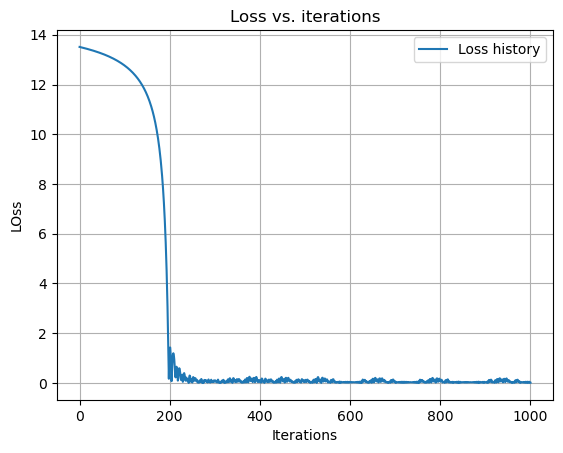

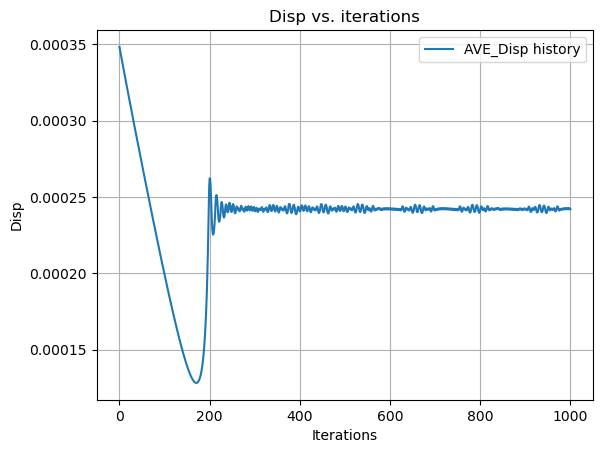

In [2]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import plotly.graph_objects as go

# q.grad.zero_()


# In[663]:


######################## explanation
## "The example model is based on a 5-nodes grid shell strcuture
##  which has a crossing projection in the x-y plane"
##  The FE part would be based on the Euler-bernoulli beam theory


# In[664]:


## Initial Geom
# Initial Coords:
node_coords = torch.tensor(
    [[0.0, 3.0, 0.0], [0.0, 6.0, 0.0], [3.0, 0.0, 0.0], [3.0, 3.0, 0.0], [3.0, 6.0, 0.0], [3.0, 9.0, 0.0],
     [6.0, 0.0, 0.0], [6.0, 3.0, 0.0], [6.0, 6.0, 0.0] ,[6.0, 9.0, 0.0], [9.0, 3.0 ,0.0], [9.0, 6.0, 0.0]],
    dtype=torch.float32, requires_grad=True, )
connectivity = [[1, 4], [2, 5], [3, 4], [5, 4], [6, 5], [4, 8], [7, 8], [9, 8],[11, 8],[10, 9],[12, 9],[5, 9]]
n_dof_per_node = 6  # Degrees of freedom per node
total_dof = n_dof_per_node * len(node_coords)
Fixed_nodes = [1, 2, 3, 6, 7, 10, 11, 12]
Free_nodes = []
n_elements = len(connectivity)
n_nodes = len(node_coords)
for i in range(1, n_nodes + 1):
    if i not in Fixed_nodes:
        Free_nodes.append(i)
idx_CF = [node - 1 for node in Fixed_nodes]
idx_CN = [i for i in range(n_nodes) if i not in idx_CF]


## Force condition
####### Force condition -> need for modification
## +0 to x direction ; +1 to y direction ; +2 to Z direction
## +3 Bending around the z axis ; +4 bending around y axis ; +5 Twisting
# implement upwards loading of 50 kN at every free nodes
F = torch.zeros(total_dof, dtype=torch.float32)
f_n = Free_nodes
f_type = [2, 2, 2, 2]  # The force type
F_value = torch.tensor([50.0, 50.0, 50.0, 50.0]) * 1000  # The force value/direction
r = 1 / torch.max(F_value)
# print(r)
F_sign = torch.sign(F_value)
for idx, i in enumerate(f_n):
    F[6 * (i - 1) + f_type[idx]] = F_value[idx]  # unit: KN / KN*m

px = torch.zeros(len(f_n), 1, dtype=torch.float32)
py = torch.zeros(len(f_n), 1, dtype=torch.float32)
pz = torch.zeros(len(f_n), 1, dtype=torch.float32)

for i in range(len(f_n)):
    if f_type[idx] == 0:
        px[i] = F_value[i]
    elif f_type[idx] == 1:
        py[i] = F_value[i]
    elif f_type[idx] == 2:
        pz[i] = F_value[i]


## Obtaining Matrix D
# Assembly the nodal-branch matrix:
C = torch.zeros(n_elements, n_nodes, dtype=torch.float32)
for n, (i, j) in enumerate(connectivity):
    C[n, i - 1] = 1
    C[n, j - 1] = -1
CF = C[:, idx_CF]
CN = C[:, idx_CN]


# Assembly D
def FDM (Q,CN=CN, CF=CF, px=px, py=py, pz=pz,Fixed_nodes=Fixed_nodes, Free_nodes=Free_nodes,node_coords=node_coords) :
    Dn = torch.matmul(torch.transpose(CN, 0, 1), torch.matmul(Q, CN))
    DF = torch.matmul(torch.transpose(CN, 0, 1), torch.matmul(Q, CF))
    ## Coordinates solution
    # separate the coordinates:
    fixed_idces = [node - 1 for node in Fixed_nodes]
    xF = node_coords[fixed_idces, 0].unsqueeze(1)
    yF = node_coords[fixed_idces, 1].unsqueeze(1)
    zF = node_coords[fixed_idces, 2].unsqueeze(1)
    xN = torch.matmul(torch.inverse(Dn), (px - torch.matmul(DF, xF)))
    yN = torch.matmul(torch.inverse(Dn), (py - torch.matmul(DF, yF)))
    zN = torch.matmul(torch.inverse(Dn), (pz - torch.matmul(DF, zF)))
    ## Coordinates renewal: 
    new_node_coords = node_coords.clone()
    for idx, node in enumerate(Free_nodes):
        node_idx = node - 1
        new_node_coords[node_idx, 0] = xN[idx]
        new_node_coords[node_idx, 1] = yN[idx]
        new_node_coords[node_idx, 2] = zN[idx]

    return new_node_coords

# In[670]:


## Check point: FDM completed
# if q.grad is not None:
#     q.grad.zero_()
# loss = torch.sum(new_node_coords[:, 2])
# loss.backward()
# print("Gradient of q:")
# print(q.grad)


############ Now comes to FE part:
#### Default values (in meters, Pascals, etc.)
## For rectangular sections
# D_width = 0.1
# D_height = 0.2
# D_young_modulus = 210e9  # Young's modulus in Pascals
# D_shear_modulus = 81e9  # Shear modulus in Pascals
# D_poisson_ratio = 0.3
# cross_section_angle_a = 0  # Cross-section angle at node 1 (anti-clockwise)
# cross_section_angle_b = 0  # Cross-section angle at node 2 (anti-clockwise)
# a_small_number = 1e-10

D_radius = 0.05
D_young_modulus = 210e9  # Young's modulus in Pascals
D_shear_modulus = 81e9  # Shear modulus in Pascals
D_poisson_ratio = 0.3
cross_section_angle_a = 0  # Cross-section angle at node 1 (anti-clockwise)
cross_section_angle_b = 0  # Cross-section angle at node 2 (anti-clockwise)
a_small_number = 1e-10


# In[673]:


def rotation(v, k, theta):
    """Rotation of vector v around axis k by angle theta."""
    k = k / torch.norm(k)  # Normalize k
    cross_product = torch.cross(k, v)
    dot_product = torch.dot(k, v)

    # Ensure theta is a tensor
    theta = torch.tensor(theta, dtype=torch.float32) if not isinstance(theta, torch.Tensor) else theta

    v_rotated = v * torch.cos(theta) + cross_product * torch.sin(theta) + k * dot_product * (1 - torch.cos(theta))
    return v_rotated


# In[674]:


###### Element Creating (euler beam)
# For rectangular sections
# class Beam:
#     def __init__(self, node_coordinates, width=D_width, height=D_height, young_modulus=D_young_modulus,
#                  shear_modulus=D_shear_modulus, poisson_ratio=D_poisson_ratio, Beta_a=cross_section_angle_a,
#                  Beta_b=cross_section_angle_b):
#         self.node_coordinates = node_coordinates  # (2, 3) tensor for node coordinates

#         # Material and geometry
#         self.width = width
#         self.height = height
#         self.young_modulus = young_modulus
#         self.shear_modulus = shear_modulus
#         self.poisson_ratio = poisson_ratio

#         # Cross-sectional properties
#         self.length = torch.norm(self.node_coordinates[1] - self.node_coordinates[0])  # Length of the beam
#         self.Iy = (self.width * self.height ** 3) / 12
#         self.Iz = (self.width ** 3 * self.height) / 12
#         self.A = self.width * self.height
#         self.J = (self.width * self.height ** 3) / 3

#         # Stiffness components
#         self.S_u = self.young_modulus * self.A / self.length
#         self.S_v1a = 12 * self.young_modulus * self.Iy / (self.length ** 3)
#         self.S_v1b = 6 * self.young_modulus * self.Iy / (self.length ** 2)
#         self.S_v2a = 12 * self.young_modulus * self.Iz / (self.length ** 3)
#         self.S_v2b = 6 * self.young_modulus * self.Iz / (self.length ** 2)
#         self.S_theta1a = 6 * self.young_modulus * self.Iy / (self.length ** 2)
#         self.S_theta1b = 4 * self.young_modulus * self.Iy / self.length
#         self.S_theta1c = 2 * self.young_modulus * self.Iy / self.length
#         self.S_theta2a = 6 * self.young_modulus * self.Iz / (self.length ** 2)
#         self.S_theta2b = 4 * self.young_modulus * self.Iz / self.length
#         self.S_theta2c = 2 * self.young_modulus * self.Iz / self.length
#         self.S_Tr = self.shear_modulus * self.J / self.length

#         # Section rotations at the two ends
#         self.Beta_a = Beta_a
#         self.Beta_b = Beta_b


# In[675]:


# For circular sections
class Beam:
    def __init__(self, node_coordinates, R=D_radius, young_modulus=D_young_modulus,
                 shear_modulus=D_shear_modulus, poisson_ratio=D_poisson_ratio, Beta_a=cross_section_angle_a,
                 Beta_b=cross_section_angle_b):
        self.node_coordinates = node_coordinates  # (2, 3) tensor for node coordinates

        # Material and geometry
        self.radius = R
        self.young_modulus = young_modulus
        self.shear_modulus = shear_modulus
        self.poisson_ratio = poisson_ratio

        # Cross-sectional properties
        self.length = torch.norm(self.node_coordinates[1] - self.node_coordinates[0])  # Length of the beam
        self.Iy = (torch.pi * self.radius ** 4) / 4 
        self.Iz = self.Iy
        self.A = torch.pi * self.radius ** 2
        self.J = (torch.pi * self.radius ** 4) / 2

        # Stiffness components
        self.S_u = self.young_modulus * self.A / self.length
        self.S_v1a = 12 * self.young_modulus * self.Iy / (self.length ** 3)
        self.S_v1b = 6 * self.young_modulus * self.Iy / (self.length ** 2)
        self.S_v2a = 12 * self.young_modulus * self.Iz / (self.length ** 3)
        self.S_v2b = 6 * self.young_modulus * self.Iz / (self.length ** 2)
        self.S_theta1a = 6 * self.young_modulus * self.Iy / (self.length ** 2)
        self.S_theta1b = 4 * self.young_modulus * self.Iy / self.length
        self.S_theta1c = 2 * self.young_modulus * self.Iy / self.length
        self.S_theta2a = 6 * self.young_modulus * self.Iz / (self.length ** 2)
        self.S_theta2b = 4 * self.young_modulus * self.Iz / self.length
        self.S_theta2c = 2 * self.young_modulus * self.Iz / self.length
        self.S_Tr = self.shear_modulus * self.J / self.length

        # Section rotations at the two ends
        self.Beta_a = Beta_a
        self.Beta_b = Beta_b

    def get_element_stiffness_matrix(self):
        """Element stiffness matrix."""
        K_element = torch.tensor([
            [self.S_u, 0, 0, 0, 0, 0, -self.S_u, 0, 0, 0, 0, 0],
            [0, self.S_v1a, 0, 0, 0, self.S_theta1a, 0, -self.S_v1a, 0, 0, 0, self.S_theta1a],
            [0, 0, self.S_v2a, 0, -self.S_theta2a, 0, 0, 0, -self.S_v2a, 0, -self.S_theta2a, 0],
            [0, 0, 0, self.S_Tr, 0, 0, 0, 0, 0, -self.S_Tr, 0, 0],
            [0, 0, -self.S_v2b, 0, self.S_theta2b, 0, 0, 0, self.S_v2b, 0, self.S_theta2c, 0],
            [0, self.S_v1b, 0, 0, 0, self.S_theta1b, 0, -self.S_v1b, 0, 0, 0, self.S_theta1c],
            [-self.S_u, 0, 0, 0, 0, 0, self.S_u, 0, 0, 0, 0, 0],
            [0, -self.S_v1a, 0, 0, 0, -self.S_theta1a, 0, self.S_v1a, 0, 0, 0, -self.S_theta1a],
            [0, 0, -self.S_v2a, 0, self.S_theta2a, 0, 0, 0, self.S_v2a, 0, self.S_theta2a, 0],
            [0, 0, 0, -self.S_Tr, 0, 0, 0, 0, 0, self.S_Tr, 0, 0],
            [0, 0, -self.S_v2b, 0, self.S_theta2c, 0, 0, 0, self.S_v2b, 0, self.S_theta2b, 0],
            [0, self.S_v1b, 0, 0, 0, self.S_theta1c, 0, -self.S_v1b, 0, 0, 0, self.S_theta1b],
        ], dtype=torch.float32)

        return K_element

    def System_Transform(self):
        """Coordinate transformation matrix."""
        vector_x = self.node_coordinates[1, 0] - self.node_coordinates[0, 0]
        vector_y = self.node_coordinates[1, 1] - self.node_coordinates[0, 1]
        vector_z = self.node_coordinates[1, 2] - self.node_coordinates[0, 2]
        length = torch.norm(self.node_coordinates[1] - self.node_coordinates[0])
        # print(vector_x,vector_y,vector_z)
        # Calculate alpha and ceta using PyTorch
        z_value = torch.clamp(vector_z / length, min=-1 + 1e-6, max=1 - 1e-6)
        ceta = torch.acos(z_value)
        value = vector_x / torch.sqrt(vector_y ** 2 + vector_x ** 2 + a_small_number)
        value = torch.clamp(value, min=-1 + 1e-6, max=1 - 1e-6)
        alpha = torch.acos(value)
        # print(alpha)

        Projection_Z_x = - vector_z / length * torch.sin(alpha)
        Projection_Z_y = - vector_z / length * torch.cos(alpha)
        Projection_Z_z = torch.cos(torch.pi / 2 - ceta)

        V_projection = torch.stack([Projection_Z_x, Projection_Z_y, Projection_Z_z])
        X_axis = torch.stack([vector_x / length, vector_y / length, vector_z / length])
        Z_axis_a = rotation(V_projection, X_axis, self.Beta_a)

        # Z_axis_b = rotation(V_projection, X_axis, self.Beta_b)
        Y_axis_a = rotation(Z_axis_a, X_axis, -torch.pi / 2)
        # Y_axis_b = rotation(Z_axis_b, X_axis, torch.pi / 2)
        Z_axis_a = Z_axis_a / torch.norm(Z_axis_a)
        # Z_axis_b = Z_axis_b / torch.norm(Z_axis_b)
        Y_axis_a = Y_axis_a / torch.norm(Y_axis_a)
        # Y_axis_b = Y_axis_b / torch.norm(Y_axis_b)

        lambda_matrix = torch.stack([X_axis, Y_axis_a, Z_axis_a], dim=0)
        matrix_T = torch.zeros((12, 12), dtype=torch.float32)
        for i in range(0, 12, 3):
            matrix_T[i:i + 3, i:i + 3] = lambda_matrix
        return matrix_T

    def nodal_transform(self):
        """Coordinate transformation matrix."""
        vector_x = self.node_coordinates[1, 0] - self.node_coordinates[0, 0]
        vector_y = self.node_coordinates[1, 1] - self.node_coordinates[0, 1]
        vector_z = self.node_coordinates[1, 2] - self.node_coordinates[0, 2]
        length = torch.norm(self.node_coordinates[1] - self.node_coordinates[0])
        # Calculate alpha and ceta using PyTorch
        z_value = torch.clamp(vector_z / length, min=-1 + 1e-6, max=1 - 1e-6)
        ceta = torch.acos(z_value)
        value = vector_x / torch.sqrt(vector_y ** 2 + vector_x ** 2 + a_small_number)
        value = torch.clamp(value, min=-1 + 1e-6, max=1 - 1e-6)
        alpha = torch.acos(value)

        Projection_Z_x = - vector_z / length * torch.sin(alpha)
        Projection_Z_y = - vector_z / length * torch.cos(alpha)
        Projection_Z_z = torch.cos(torch.pi / 2 - ceta)

        V_projection = torch.stack([Projection_Z_x, Projection_Z_y, Projection_Z_z])
        X_axis = torch.stack([vector_x / length, vector_y / length, vector_z / length])
        Z_axis_a = rotation(V_projection, X_axis, self.Beta_a)

        # Z_axis_b = rotation(V_projection, X_axis, self.Beta_b)
        Y_axis_a = rotation(Z_axis_a, X_axis, -torch.pi / 2)
        # Y_axis_b = rotation(Z_axis_b, X_axis, torch.pi / 2)
        Z_axis_a = Z_axis_a / torch.norm(Z_axis_a)
        # Z_axis_b = Z_axis_b / torch.norm(Z_axis_b)
        Y_axis_a = Y_axis_a / torch.norm(Y_axis_a)
        # Y_axis_b = Y_axis_b / torch.norm(Y_axis_b)

        lambda_matrix = torch.stack([X_axis, Y_axis_a, Z_axis_a], dim=0)

        return lambda_matrix


# In[676]:


def assemble_stiffness_matrix(beams, n_nodes, n_dof_per_node, connectivity):
    """Global stiffness matrix assembly."""
    total_dof = n_nodes * n_dof_per_node  # Total degrees of freedom
    K_global = torch.zeros((total_dof, total_dof), dtype=torch.float32)
    for idx, (i, j) in enumerate(connectivity):
        Matrix_T = beams[idx].System_Transform()  # Get transformation matrix

        K_element = torch.matmul(torch.transpose(Matrix_T, 0, 1),
                                 torch.matmul(beams[idx].get_element_stiffness_matrix(), Matrix_T))

        start_idx = (i - 1) * n_dof_per_node
        end_idx = (j - 1) * n_dof_per_node
        K_global[start_idx:start_idx + 6, start_idx:start_idx + 6] = K_global[start_idx:start_idx + 6,
                                                                     start_idx:start_idx + 6] + K_element[0:6, 0:6]
        K_global[end_idx:end_idx + 6, end_idx:end_idx + 6] = K_global[end_idx:end_idx + 6,
                                                             end_idx:end_idx + 6] + K_element[6:12, 6:12]
        K_global[start_idx:start_idx + 6, end_idx:end_idx + 6] = K_global[start_idx:start_idx + 6,
                                                                 end_idx:end_idx + 6] + K_element[0:6, 6:12]
        K_global[end_idx:end_idx + 6, start_idx:start_idx + 6] = K_global[end_idx:end_idx + 6,
                                                                 start_idx:start_idx + 6] + K_element[6:12, 0:6]

    return K_global


# In[677]:


def Strain_E(node_coords, connectivity, fixed_dof, F):
    # node_coords[:, 2] = 0.0
    # Element Assembly
    beams = []
    for connection in connectivity:
        node_1_coords = node_coords[connection[0] - 1]
        node_2_coords = node_coords[connection[1] - 1]
        beam = Beam(node_coordinates=torch.stack([node_1_coords, node_2_coords]),
                    R=D_radius, young_modulus=D_young_modulus,
                    shear_modulus=D_shear_modulus, poisson_ratio=D_poisson_ratio, Beta_a=cross_section_angle_a,
                    Beta_b=cross_section_angle_b)
        beams.append(beam)
    # Stiffness renewal
    K_global = assemble_stiffness_matrix(beams, n_nodes=len(node_coords), n_dof_per_node=6, connectivity=connectivity)
    K_global[fixed_dof, :] = K_global[fixed_dof, :] - K_global[fixed_dof, :]
    K_global[:, fixed_dof] = K_global[:, fixed_dof] - K_global[:, fixed_dof]
    K_global[fixed_dof, fixed_dof] = 1e5
    rank_K = torch.linalg.matrix_rank(K_global)

    if rank_K < K_global.shape[0]:
        print("Warning: The stiffness matrix is not of full rank")
    else:
        displacements = torch.linalg.solve(K_global, F)

    # Compute strain energy
    strain_energy_list = []
    Local_d = torch.zeros(len(connectivity), 12, dtype=torch.float32)
    for n, (i, j) in enumerate(connectivity):
        matrix_T = beams[n].System_Transform()
        Tep_displacements = torch.cat(
            [displacements[6 * (i - 1):6 * (i - 1) + 6], displacements[6 * (j - 1):6 * (j - 1) + 6]], dim=0)
        Local_d_n = torch.matmul(Tep_displacements, matrix_T.T)
        Local_d[n, :] = Local_d_n.clone()
        K_g = torch.matmul(torch.transpose(matrix_T, 0, 1),
                           torch.matmul(beams[n].get_element_stiffness_matrix(), matrix_T))

        strain_energy_list.append(torch.matmul(Local_d_n, torch.matmul(K_g, Local_d_n.reshape(-1, 1))))

    Strain_energy = torch.stack(strain_energy_list)

    return Strain_energy, Local_d, displacements, beams

def Average_height(Free_nodes, new_node_coords):
    n_free_nodes = len(Free_nodes)
    Free_nodes = torch.tensor(Free_nodes)
    AH = torch.sum(new_node_coords[(Free_nodes - 1), 2])/ n_free_nodes
    return AH

# In[678]:


# Element creating
#################  input below:
############################################################################################################## input
# initial coordinates

####### BCs
fixed_dof = []
for node in Fixed_nodes:
    fixed_dof.extend([(node - 1) * 6 + i for i in range(6)])
# print(fixed_dof)
####### Gradient descent
step = 0.001
epochs = 1000
Obj_coords = 15
####### Plotting
steps = 20  # steps for tracing deformation shape
###################################################################################################################################################
###################################################################################################################################################


# In[679]:

# Optimized Variables
## initial variables
q = torch.rand(1, requires_grad=True)
## Optimization
torch.autograd.set_detect_anomaly(True)
# Optimizer setting
optimizer = optim.Adam([q], lr=step)
# Initilizing
# New_Coordinates = torch.zeros(n_nodes * 3, dtype=torch.float32)
Loss_his = []
Disp_his = []
# Loop start
for iteration in range(epochs + 1):
    print('ite',iteration)
    # Forwards
    q_vec = q.expand(n_elements)
    Q = torch.diag(q_vec) * 1 / r  # scaling
    new_node_coords = FDM(Q)
    N_coords = new_node_coords.clone()
    Strain_energy, _, displacements, _ = Strain_E(N_coords, connectivity, fixed_dof, F)
    idx = 6 * torch.arange(n_nodes) + 2
    Ave_Disp = abs(torch.sum(displacements[idx] / len(Free_nodes)))
    Disp_his.append(Ave_Disp.item())
    N_coords = N_coords.reshape(-1)
    New_Coordinates = torch.zeros(n_nodes * 3, dtype=torch.float32)
    for n in range(n_nodes):
        New_Coordinates[3*n : 3*n+3] = N_coords[3*n : 3*n+3] + displacements[6*n : 6*n+3]
    New_Coordinates = New_Coordinates.view(n_nodes, 3).clone()
    AVE = Average_height(Free_nodes, New_Coordinates)
    print("Average height",AVE)
    # loss
    Loss = torch.norm(AVE - Obj_coords)
    Loss_his.append(Loss.item())
    # Backwards
    optimizer.zero_grad()
    # print(q.grad)
    Loss.backward(retain_graph=True)

    # Grad
    gradients = q.grad
    print('Grad',gradients)
    frob_norm = torch.norm(gradients)
    optimizer.step()
    
    # print iteration
    if iteration % 5 == 0:
        print(f"Iteration {iteration}: Normalized Gradient = {frob_norm}, Adaptive learning rate = {step}")
print("Optimization completed.")
print(q)
# print("coordinates:",node_coords)

#############################################################################################################
## Visualization
# print(Coordinates)
# displacements = Strain_E(node_coords, connectivity, fixed_dof, F)[2]
# print("displacements:", displacements)
print("Deformed:", New_Coordinates)

new_node_coords = new_node_coords.reshape(-1)
New_Coordinates = New_Coordinates.reshape(-1)
x_orig = new_node_coords[0::3]
y_orig = new_node_coords[1::3]
z_orig = new_node_coords[2::3]
# z_orig = torch.zeros_like(z_orig)
x_new = New_Coordinates[0::3]
y_new = New_Coordinates[1::3]
z_new = New_Coordinates[2::3]

fig = go.Figure()

for connection in connectivity:
    i, j = connection
    fig.add_trace(go.Scatter3d(
        x=[x_orig[i-1].item(), x_orig[j-1].item()],
        y=[y_orig[i-1].item(), y_orig[j-1].item()],
        z=[z_orig[i-1].item(), z_orig[j-1].item()],
        mode='lines',
        line=dict(color='blue', width=2),
        name='Original Geom'
    ))

for connection in connectivity:
    i, j = connection
    fig.add_trace(go.Scatter3d(
        x=[x_new[i-1].item(), x_new[j-1].item()],
        y=[y_new[i-1].item(), y_new[j-1].item()],
        z=[z_new[i-1].item(), z_new[j-1].item()],
        mode='lines',
        line=dict(color='red', width=2),
        name='Deformed Geom (1st order)'
    ))


fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data' 
    ),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

fig.show()
########################################################################################################################
# # SHape function embedding:
# # Define a function to compute local_d and global displacements for multiple x values between 0 and L
# def compute_local_and_global_displacements(n_elements, beams, Local_d, steps):
#     glob_mid_dis = torch.zeros(n_elements, 3 * (steps+1), dtype=torch.float32)  # Global displacements
#     mid_coords = torch.zeros(n_elements, 3 * (steps+1), dtype=torch.float32)  # Store displacements for multiple points (20 points per segment)

#     for n in range(n_elements):
#         l = beams[n].length
#         x_values = torch.linspace(0, l, steps=steps + 1)  # 20 points from 0 to L
#         for i, x in enumerate(x_values):
#             # Find the original coordinates for this point in the element
#             # We interpolate to find the coordinates based on the x value.
#             # The original coordinates of the element's two nodes (start and end)
#             x1, y1, z1 = beams[n].node_coordinates[0, 0], beams[n].node_coordinates[0, 1], beams[n].node_coordinates[0, 2]  # First node
#             x2, y2, z2 = beams[n].node_coordinates[1, 0], beams[n].node_coordinates[1, 1], beams[n].node_coordinates[1, 2]  # Second node

#             # Interpolate to get the coordinates at the current x
#             t = x / l  # Proportional distance from 0 to l
#             interp_x = (1 - t) * x1 + t * x2
#             interp_y = (1 - t) * y1 + t * y2
#             interp_z = (1 - t) * z1 + t * z2

#             # Calculate the local displacement for this point (same formula as before)
#             disp_x = (1 - x / l) * Local_d[n, 0] + (x / l) * Local_d[n, 6]
#             disp_y = (1 - 3 * x ** 2 / l ** 2 + 2 * x ** 3 / l ** 3) * Local_d[n, 1] + \
#                      (x - 2 * x ** 2 / l + x ** 3 / l ** 2) * Local_d[n, 3] + \
#                      (3 * x ** 2 / l ** 2 - 2 * x ** 3 / l ** 3) * Local_d[n, 7] + \
#                      (-x ** 2 / l + x ** 3 / l ** 2) * Local_d[n, 9]
#             disp_z = (1 - 3 * x ** 2 / l ** 2 + 2 * x ** 3 / l ** 3) * Local_d[n, 2] + \
#                      (x - 2 * x ** 2 / l + x ** 3 / l ** 2) * Local_d[n, 4] + \
#                      (3 * x ** 2 / l ** 2 - 2 * x ** 3 / l ** 3) * Local_d[n, 8] + \
#                      (-x ** 2 / l + x ** 3 / l ** 2) * Local_d[n, 10]

#             # Create a tensor for the displacements (x, y, z)
#             tep_cords = torch.tensor([disp_x, disp_y, disp_z], dtype=torch.float32)  # Ensure it's a tensor of shape [3]

#             # Apply the nodal transformation to compute global displacement
#             M = beams[n].nodal_transform()  # Get nodal transformation matrix
#             M = torch.transpose(M, 0, 1)  # Transpose M if needed
#             Cords = torch.matmul(tep_cords, torch.linalg.inv(M))  # Apply transformation

#             glob_mid_dis[n, 3*i : 3*i+3] = Cords
#             # print(glob_mid_dis)
#             # Now update the coordinates by adding global displacement to the interpolated coordinates
#             new_x = interp_x + glob_mid_dis[n, 3*i]
#             new_y = interp_y + glob_mid_dis[n, 3*i + 1]
#             new_z = interp_z + glob_mid_dis[n, 3*i + 2]

#             # Store the updated coordinates
#             mid_coords[n, 3*i] = new_x
#             mid_coords[n, 3*i + 1] = new_y
#             mid_coords[n, 3*i + 2] = new_z

#     return mid_coords, glob_mid_dis


# Local_d = Strain_E(node_coords, connectivity, fixed_dof, F)[1]
# beams = Strain_E(node_coords, connectivity, fixed_dof, F)[3]
# mid_coords, glob_mid_dis = compute_local_and_global_displacements(n_elements, beams, Local_d,steps)
# # print(glob_mid_dis)
# # # print(mid_coords)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for connection in connectivity:
#     i, j = connection
#     ax.plot([x_orig[i-1].item(), x_orig[j-1].item()], [y_orig[i-1].item(), y_orig[j-1].item()], [z_orig[i-1].item(), z_orig[j-1].item()], color='blue')
#     ax.plot([0, 0], [0, 0], [0, 0], color='red')

# for n in range(mid_coords.shape[0]):
#     x_vals = mid_coords[n, 0::3]
#     y_vals = mid_coords[n, 1::3]
#     z_vals = mid_coords[n, 2::3]
#     ax.plot(x_vals.tolist(), y_vals.tolist(), z_vals.tolist(), color='red')

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.invert_yaxis()

# # node_label = f"F = {{{F_value}}} KN at node{{{f_n-1}}}"
# # ax.text(0.1, -0.5, 1.6, node_label, color='black')
# ax.legend(['Original Geom', 'Deformed Geom (3rd order)'])

# plt.show()

### Plot the optimization history
plt.figure()
plt.plot(range(epochs + 1), Loss_his, label='Loss history')
plt.xlabel('Iterations')
plt.ylabel('LOss')
plt.title('Loss vs. iterations')
plt.legend()
plt.grid(True)


plt.figure()
plt.plot(range(epochs + 1), Disp_his, label='AVE_Disp history')
plt.xlabel('Iterations')
plt.ylabel('Disp')
plt.title('Disp vs. iterations')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
### With no Optimizer

0
tensor([[0.0000, 3.0000, 0.0000],
        [0.0000, 6.0000, 0.0000],
        [3.0000, 0.0000, 0.0000],
        [3.0000, 3.0000, 5.0880],
        [3.0000, 6.0000, 5.0880],
        [3.0000, 9.0000, 0.0000],
        [6.0000, 0.0000, 0.0000],
        [6.0000, 3.0000, 5.0880],
        [6.0000, 6.0000, 5.0880],
        [6.0000, 9.0000, 0.0000],
        [9.0000, 3.0000, 0.0000],
        [9.0000, 6.0000, 0.0000]], grad_fn=<CloneBackward0>)
tensor(5.0880, grad_fn=<DivBackward0>)
tensor([[0.0000, 3.0000, 0.0000],
        [0.0000, 6.0000, 0.0000],
        [3.0000, 0.0000, 0.0000],
        [3.0000, 3.0000, 5.0880],
        [3.0000, 6.0000, 5.0880],
        [3.0000, 9.0000, 0.0000],
        [6.0000, 0.0000, 0.0000],
        [6.0000, 3.0000, 5.0880],
        [6.0000, 6.0000, 5.0880],
        [6.0000, 9.0000, 0.0000],
        [9.0000, 3.0000, 0.0000],
        [9.0000, 6.0000, 0.0000]], grad_fn=<CopySlices>)
Iteration 0: Normalized Gradient = 51.77470397949219, Adaptive learning rate = 0.001
1
tensor

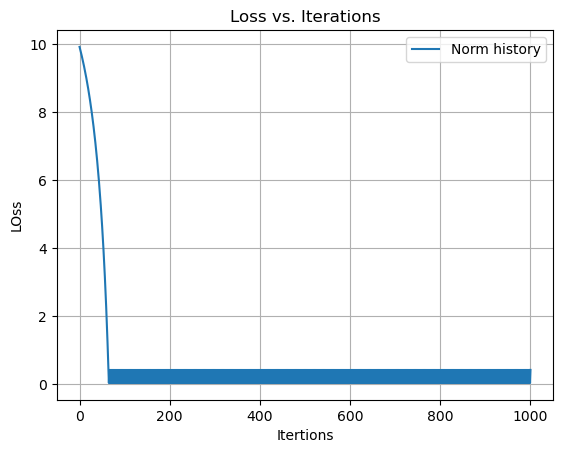

In [6]:
###### With none-FE part

import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import plotly.graph_objects as go

# q.grad.zero_()


# In[663]:


######################## explanation
## "The example model is based on a 5-nodes grid shell strcuture
##  which has a crossing projection in the x-y plane"
##  The FE part would be based on the Euler-bernoulli beam theory


# In[664]:


## Initial Geom
# Initial Coords:
node_coords = torch.tensor(
    [[0.0, 3.0, 0.0], [0.0, 6.0, 0.0], [3.0, 0.0, 0.0], [3.0, 3.0, 0.0], [3.0, 6.0, 0.0], [3.0, 9.0, 0.0],
     [6.0, 0.0, 0.0], [6.0, 3.0, 0.0], [6.0, 6.0, 0.0] ,[6.0, 9.0, 0.0], [9.0, 3.0 ,0.0], [9.0, 6.0, 0.0]],
    dtype=torch.float32, requires_grad=True, )
connectivity = [[1, 4], [2, 5], [3, 4], [5, 4], [6, 5], [4, 8], [7, 8], [9, 8],[11, 8],[10, 9],[12, 9],[5, 9]]
n_dof_per_node = 6  # Degrees of freedom per node
total_dof = n_dof_per_node * len(node_coords)
Fixed_nodes = [1, 2, 3, 6, 7, 10, 11, 12]
Free_nodes = []
n_elements = len(connectivity)
n_nodes = len(node_coords)
for i in range(1, n_nodes + 1):
    if i not in Fixed_nodes:
        Free_nodes.append(i)
idx_CF = [node - 1 for node in Fixed_nodes]
idx_CN = [i for i in range(n_nodes) if i not in idx_CF]

# In[665]:


## Force condition
####### Force condition -> need for modification
## +0 to x direction ; +1 to y direction ; +2 to Z direction
## +3 Bending around the z axis ; +4 bending around y axis ; +5 Twisting
# implement upwards loading of 50 kN at every free nodes
F = torch.zeros(total_dof, dtype=torch.float32)
f_n = Free_nodes
f_type = [2, 2, 2, 2]  # The force type
F_value = torch.tensor([50.0, 50.0, 50.0, 50.0]) * 1000  # The force value/direction
r = 1 / torch.max(F_value)
# print(r)
F_sign = torch.sign(F_value)
for idx, i in enumerate(f_n):
    F[6 * (i - 1) + f_type[idx]] = F_value[idx]  # unit: KN / KN*m

px = torch.zeros(len(f_n), 1, dtype=torch.float32)
py = torch.zeros(len(f_n), 1, dtype=torch.float32)
pz = torch.zeros(len(f_n), 1, dtype=torch.float32)

for i in range(len(f_n)):
    if f_type[idx] == 0:
        px[i] = F_value[i]
    elif f_type[idx] == 1:
        py[i] = F_value[i]
    elif f_type[idx] == 2:
        pz[i] = F_value[i]


## Obtaining Matrix D
# Assembly the nodal-branch matrix:
C = torch.zeros(n_elements, n_nodes, dtype=torch.float32)
for n, (i, j) in enumerate(connectivity):
    C[n, i - 1] = 1
    C[n, j - 1] = -1
CF = C[:, idx_CF]
CN = C[:, idx_CN]


# Assembly D
def FDM (Q,CN=CN, CF=CF, px=px, py=py, pz=pz,Fixed_nodes=Fixed_nodes, Free_nodes=Free_nodes,node_coords=node_coords) :
    Dn = torch.matmul(torch.transpose(CN, 0, 1), torch.matmul(Q, CN))
    DF = torch.matmul(torch.transpose(CN, 0, 1), torch.matmul(Q, CF))
    ## Coordinates solution
    # separate the coordinates:
    fixed_idces = [node - 1 for node in Fixed_nodes]
    xF = node_coords[fixed_idces, 0].unsqueeze(1)
    yF = node_coords[fixed_idces, 1].unsqueeze(1)
    zF = node_coords[fixed_idces, 2].unsqueeze(1)
    xN = torch.matmul(torch.inverse(Dn), (px - torch.matmul(DF, xF)))
    yN = torch.matmul(torch.inverse(Dn), (py - torch.matmul(DF, yF)))
    zN = torch.matmul(torch.inverse(Dn), (pz - torch.matmul(DF, zF)))
    ## Coordinates renewal: 
    new_node_coords = node_coords.clone()
    for idx, node in enumerate(Free_nodes):
        node_idx = node - 1
        new_node_coords[node_idx, 0] = xN[idx]
        new_node_coords[node_idx, 1] = yN[idx]
        new_node_coords[node_idx, 2] = zN[idx]

    return new_node_coords

# In[670]:

## Check point: FDM completed
# if q.grad is not None:
#     q.grad.zero_()
# loss = torch.sum(new_node_coords[:, 2])
# loss.backward()
# print("Gradient of q:")
# print(q.grad)



# Element creating
#################  input below:
############################################################################################################## input
# initial coordinates

####### BCs
fixed_dof = []
for node in Fixed_nodes:
    fixed_dof.extend([(node - 1) * 6 + i for i in range(6)])
# print(fixed_dof)
####### Gradient descent
step = 0.001
epochs = 1000

####### Plotting
steps = 20  # steps for tracing deformation shape
###################################################################################################################################################
###################################################################################################################################################


### Defining the OBJ:
Obj_coords = 15
def Average_height(Free_nodes, new_node_coords):
    n_free_nodes = len(Free_nodes)
    Free_nodes = torch.tensor(Free_nodes)
    AH = torch.sum(new_node_coords[(Free_nodes - 1), 2])/ n_free_nodes
    return AH

# In[679]:

# Optimized Variables
## initial variables
q = torch.rand(1, requires_grad=True)
## Optimization
torch.autograd.set_detect_anomaly(True)
# Optimizer setting
# optimizer = optim.Adam([q], lr=step)
# Loop start
Loss_his = []
for iteration in range(epochs + 1):
    print(iteration)
    # Forwards
    q_vec = q.expand(n_elements)
    Q = torch.diag(q_vec) * 1 / r  # scaling
    new_node_coords = FDM(Q)
    N_coords = new_node_coords.clone()
    print(N_coords)
    AVE = Average_height(Free_nodes, N_coords)
    print(AVE)
    # loss
    Loss = torch.norm(AVE - Obj_coords)
    Loss_his.append(Loss.item())
    # Backwards
    if q.grad is not None:
        q.grad.zero_()
    # print(q.grad)
    Loss.backward(retain_graph=True)

    # Grad
    gradients = q.grad
    frob_norm = torch.norm(gradients)
#     print(gradients)
#     optimizer.step()
    q = q -  gradients / frob_norm * step
    q = q.detach().requires_grad_(True)
    print(new_node_coords)
    # print iteration
    if iteration % 5 == 0:
        print(f"Iteration {iteration}: Normalized Gradient = {frob_norm}, Adaptive learning rate = {step}")
print("Optimization completed.")
print(q)
# print("coordinates:",node_coords)

#############################################################################################################
# Coordinates assembly:
Coordinates = new_node_coords.reshape(-1)
# print(Coordinates)
## Coordinates renewal:
New_Coordinates = torch.zeros(n_nodes * 3, dtype=torch.float32)

x_orig = Coordinates[0::3]
y_orig = Coordinates[1::3]
z_orig = Coordinates[2::3]
fig = go.Figure()

for connection in connectivity:
    i, j = connection
    fig.add_trace(go.Scatter3d(
        x=[x_orig[i-1].item(), x_orig[j-1].item()],
        y=[y_orig[i-1].item(), y_orig[j-1].item()],
        z=[z_orig[i-1].item(), z_orig[j-1].item()],
        mode='lines',
        line=dict(color='blue', width=2),
        name='Original Geom'
    ))


for node in Free_nodes:
    fig.add_trace(go.Cone(
        x=[x_orig[node-1].item()],  
        y=[y_orig[node-1].item()],  
        z=[z_orig[node-1].item()],  
        u=[0],  
        v=[0],  
        w=[1],  
        sizemode='scaled',
        sizeref=0.5, 
        anchor='tail',  
        colorscale=[[0, 'red'], [1, 'red']],  
        showscale=False,
        name=f'Free Node {node}'
    ))



fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data' 
    ),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

fig.show()
### Plot the optimization history
plt.figure()
plt.plot(range(epochs + 1), Loss_his, label='Norm history')
plt.xlabel('Itertions')
plt.ylabel('LOss')
plt.title('Loss vs. Iterations')
plt.legend()
plt.grid(True)
plt.show()